In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import griddata

In [13]:
# Camera Specifications
FOV = 63.75
N_x = 80
N_y = 60
focal_length = 1.3669e-3
pixel_size   = 17e-6
angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
radians_per_pixel = np.radians(angles_per_pixel)
print(angles_per_pixel, radians_per_pixel)
# Camera Constants
const = pixel_size/focal_length
FOV_x = radians_per_pixel * N_x
FOV_y = radians_per_pixel * N_y
print(np.degrees(FOV_x), np.degrees(FOV_y))

# Frame Specification
altitude = 1630        # Albuquerque Height above sea-level

# ME Building Localization
latitude  = 35.082074
longitude = -106.625857

file_name = '/Users/Guille/Desktop/geospatial_transformation/data/sample_images.pkl'
dataset_  = pickle.load(open(file_name,'rb'))
print(len(dataset_))

0.6375 0.01112647398146385
51.0 38.25
30


In [14]:
height  = 10000
epsilon = np.radians(30)
r       = 1e25

a = 1 + np.tan(epsilon)**2
b = 2. * r * np.tan(epsilon)
c = - height * (height + 2.*r)

b_ = np.array((a, b, c))
x_ = np.roots(b_)
print(x_)

x = height/np.tan(epsilon)
print(x)

[-8.66025404e+24  1.73205081e+04]
17320.508075688776


In [15]:
height  = 10000
epsilon = np.radians(30)
r       = 1e25

a = 1 + np.tan(epsilon)**2
b = 2. * r * np.tan(epsilon)
c = - height * (height + 2.*r)

b_ = np.array((a, b, c))
x_ = np.roots(b_)
print(x_)

x = height/np.tan(epsilon)
print(x)


z = 10000.
azimuth = 10
r       = 1e25

r = ( (4.*r*height - 2.*height**2)/z ) + 2.*z

a = 1. + np.tan(azimuth)**2 
b = -2.*r - 2.* z * (np.tan(azimuth)**2)
c = (z**2) * (np.tan(azimuth)**2)

b_ = np.array((a, b, c))
x_ = np.roots(b_)
print(x_)

[-8.66025404e+24  1.73205081e+04]
17320.508075688776
[5.63232825e+25 5.25464703e-19]


In [16]:
def _circle_perspective_reprojection(N_x, N_y, epsilon, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
       
    # Project the Cross-Section plane in the Camera pLane in y-axis
    def __y_axis(epsilon_, height, R, r):
        
        # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(epsilon_, height, R, r):
            N = epsilon_.shape[0]
            # Compute quadratic formula coefficients for each elevation angle in a frame
            a_ = 1 + np.tan(epsilon_)**2
            b_ = 2. * r * np.tan(epsilon_)
            c_ = - np.ones(N) * height * (1. + 2.*r)
            #a_ = 1. + np.tan(epsilon_)**2
            #b_ = - 2. * r * np.tan(epsilon_)
            #c_ = - np.ones(N) * (R**2 - r**2)
            return np.stack((a_, b_, c_))
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, e_, height):
            N = e_.shape[0]
            x_ = np.zeros(N)
            y_ = np.zeros(N)
            z_ = np.zeros(N)
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                x_[i] = np.roots(W_[:, i])[1]
                y_[i] = x_[i] * np.tan(e_[i])
                z_[i] = y_[i] / np.sin(e_[i])
            return x_, y_, z_
    
        W_ = ___quadratic_coefficient(epsilon_, height, R, r)
        x_, y_, z_ = ___solve_quadratic_formula(W_, epsilon_, height)
        y_hat_ = r*np.arcsin(x_/r)
        y_hat_ = y_hat_ - y_hat_[0]
        return np.tile(y_hat_, (N_x, 1)).T, z_
    
    
   # Project the Cross-Section plane in the Camera pLane in x-axis
    def __x_axis(azimuth_, z_, height, R, r):
     # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(azimuth_, z_, r_, height, R):
            N = z_.shape[0]
            M = azimuth_.shape[0]
            W_ = np.zeros((N, M, 3))
            # Compute quadratic formula coefficients for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    W_[i,j,0] = 1. + np.tan(azimuth_[j])**2 
                    W_[i,j,1] = -2.*r_[i] - 2.*z_[i]* (np.tan(azimuth_[j])**2)
                    W_[i,j,2] = (z_[i]**2) * (np.tan(azimuth_[j])**2)
            return W_
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R):
            N = W_.shape[0]
            M = W_.shape[1]
            L_ = np.zeros((N, M))
            X_hat_ = np.zeros((N, M))
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    L_[i,j] = np.roots(W_[i, j, :])[1]
                    X_hat_[i,j] = r_[i]*np.arcsin(( (z_[i] - L_[i,j]) * np.tan(azimuth_[j]))/r_[i])
            return X_hat_
        r_ = np.zeros((z_.shape[0]))
        for i in range(z_.shape[0]):
            r_[i] = ( (4.*R*height - 2.*height**2)/z_[i] ) + 2.*z_[i]
        W_ = ___quadratic_coefficient(azimuth_, z_, r_, height, R)
        X_hat_ = ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R)
        return X_hat_
    
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        e_0  = epsilon + (N_y/2)*radians_per_pixel
        e_1  = epsilon - (N_y/2)*radians_per_pixel
        de   = (e_0 - e_1)/2.
        e_0_ = np.linspace(epsilon + de, epsilon + radians_per_pixel/2., int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel/2., epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Extend azimuth from camera FOV Angle for each pixel
    def __coordiantes_azimuth(N_x, radians_per_pixel):
        azimuth_ = np.linspace(0, N_x - 1, N_x)
        azimuth_ -= (N_x - 1)/2.
        azimuth_ *= radians_per_pixel
        return azimuth_
    
    # Elevation Angle from Degrees to Radiantes
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Sky-Parcel Geometric Constants
    r_earth = 6371000.     # Average Earth radius
    r = r_earth #+ altitude
    height = height - altitude
    R = r + height
    
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    azimuth_ = __coordiantes_azimuth(N_x, radians_per_pixel)

    # Get the axis distance and differential distances
    Y_, z_ = __y_axis(epsilon_, height, R, r) 
    X_ = __x_axis(azimuth_, z_, height, R, r)
    return X_, Y_

def _flat_perspective_reprojection(N_x, N_y, epsilon, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, pixel_size, focal_length):
        c = pixel_size/focal_length
        return X_ * c, Y_ * c
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y):
        z_    = height/np.sin(epsilon_)
        X_p_ *= np.tile(z_, (N_x, 1)).T
        Y_p_ *= np.tile(z_, (N_x, 1)).T
        return X_p_, Y_p_
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        e_0  = epsilon + (N_y/2)*radians_per_pixel
        e_1  = epsilon - (N_y/2)*radians_per_pixel
        de   = (e_0 - e_1)/2.
        e_0_ = np.linspace(epsilon + de, epsilon + radians_per_pixel/2., int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel/2., epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Sky-Parcel Geometric Constants
    height  = height - altitude
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    
    # Sun's Position on the Cartenian Coordiantes
    X_, Y_ = np.meshgrid(np.linspace(0., N_x - 1., N_x), np.linspace(0., N_y - 1., N_y))
    X_ -= 39.5
    Y_ -= 29.5
    
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, pixel_size, focal_length)
    
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    return X_pp_, Y_pp_

30
30.832934773000943 277.0623498675715


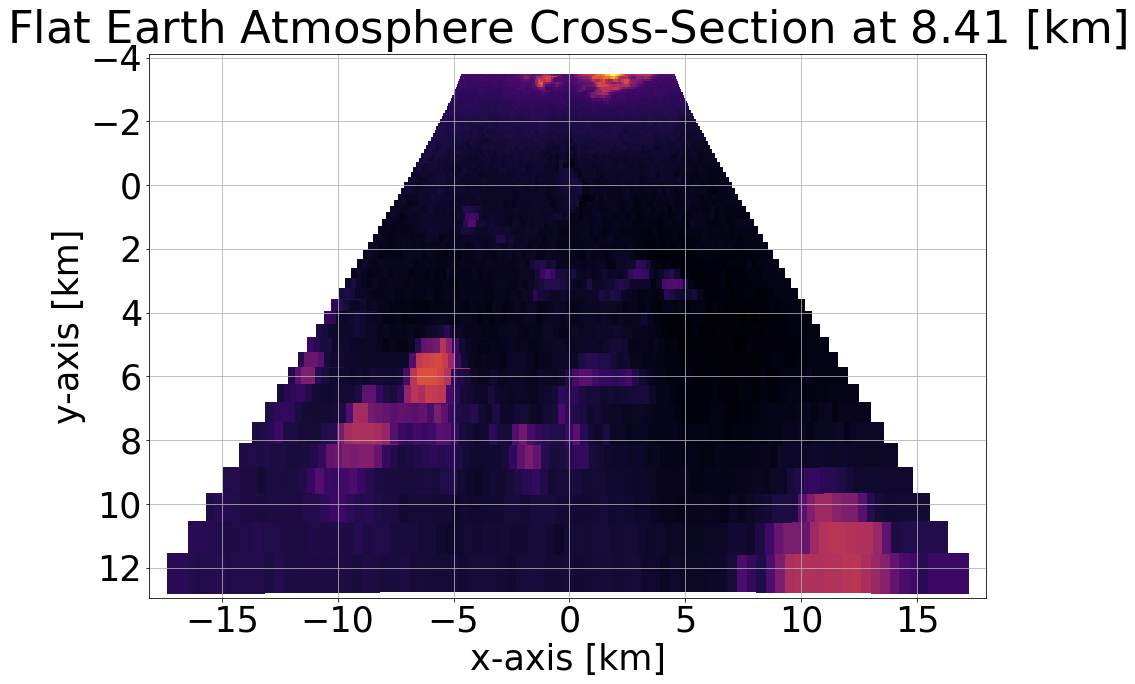

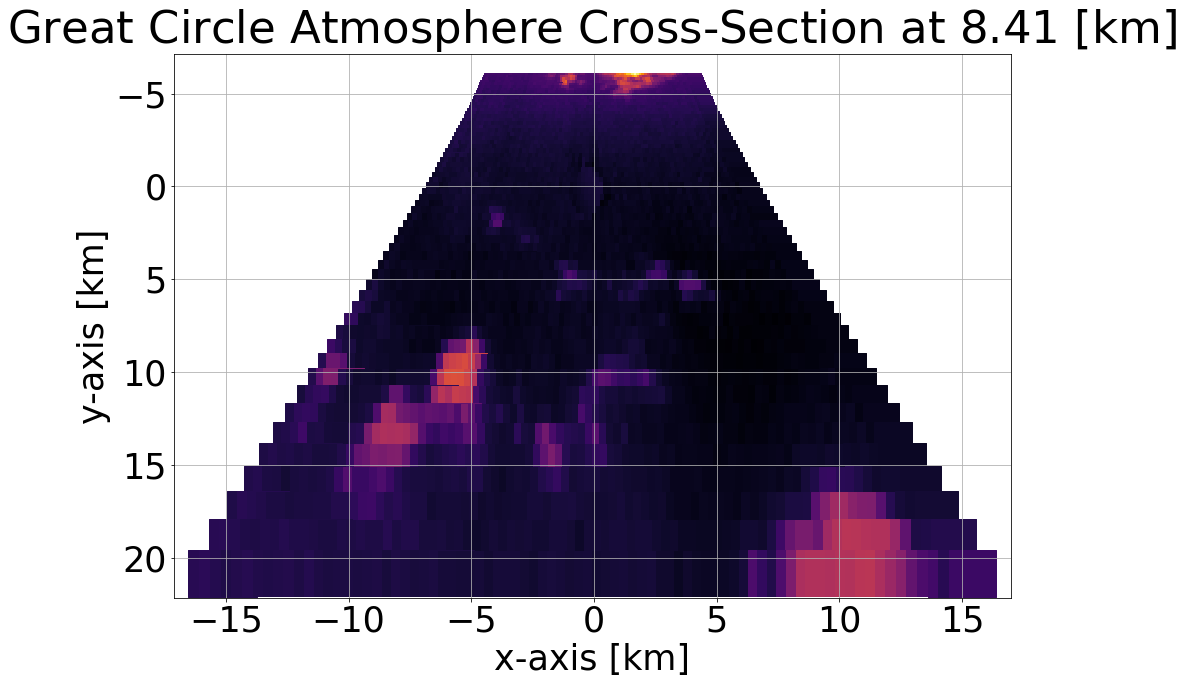

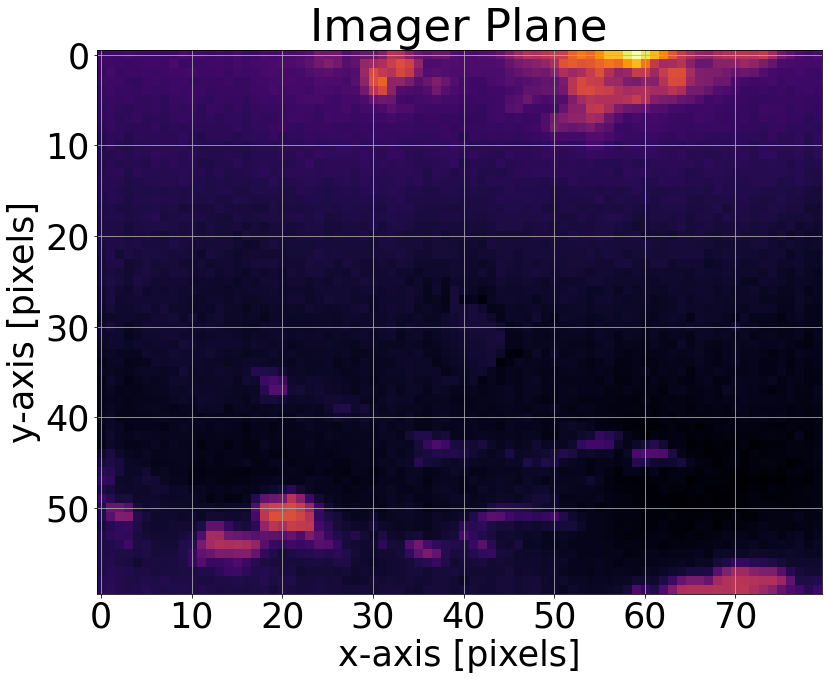

In [32]:
print(len(dataset_))
# 2 11 21
el, az, I_segm_2_, H_2_, K_2_, I_norm_2_ = dataset_[21]
I_ = K_2_.reshape(K_2_.shape[0]*K_2_.shape[1])
print(el, az)
# Camera Parameters
epsilon = el
azimuth = az
height  = np.mean(H_2_[I_segm_2_])
x_sun_  = [30, 40]

X_flat_, Y_flat_ = _flat_perspective_reprojection(N_x, N_y, epsilon, height)
X_circ_, Y_circ_ = _circle_perspective_reprojection(N_x, N_y, epsilon, height)

X_flat_ -= X_flat_[30, 40]
Y_flat_ -= Y_flat_[30, 40]

x_0 = X_circ_[30, 40]
y_0 = Y_circ_[30, 40]
X_circ_ -= x_0
Y_circ_ -= y_0

dX_flat_, dY_flat_ = _flat_perspective_reprojection_inc(N_x, N_y, epsilon, height)
dX_circ_, dY_circ_ = _circle_perspective_reprojection_inc(N_x, N_y, epsilon, height)

dZ_flat_ = np.sqrt(dX_flat_**2 +  dY_flat_**2)
dZ_circ_ = np.sqrt(dX_circ_**2 +  dY_circ_**2)

plt.figure(figsize = (15, 10))
plt.title(r'Flat Earth Atmosphere Cross-Section at ${}$ [km]'.format(np.around(height/1000, 2)), fontsize = 45)
plt.scatter(X_flat_/1000., Y_flat_/1000., c = K_2_, s = dZ_flat_*1.2, marker = 's', cmap = 'inferno')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [km]', fontsize = 35)
plt.ylabel('y-axis [km]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

plt.figure(figsize = (15, 10))
plt.title(r'Great Circle Atmosphere Cross-Section at ${}$ [km]'.format(np.around(height/1000, 2)), fontsize = 45)
plt.scatter(X_circ_/1000., Y_circ_/1000., c = K_2_, s = dZ_circ_*1.2, marker = 's', cmap = 'inferno')
plt.grid()
plt.gca().invert_yaxis()
plt.xlabel('x-axis [km]', fontsize = 35)
plt.ylabel('y-axis [km]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

plt.figure(figsize = (15, 10))
plt.title(r'Imager Plane', fontsize = 45)
plt.imshow(K_2_, cmap = 'inferno')
plt.grid()
plt.xlabel('x-axis [pixels]', fontsize = 35)
plt.ylabel('y-axis [pixels]', fontsize = 35)
plt.xticks(fontsize = 35)
plt.yticks(fontsize = 35)
plt.show()

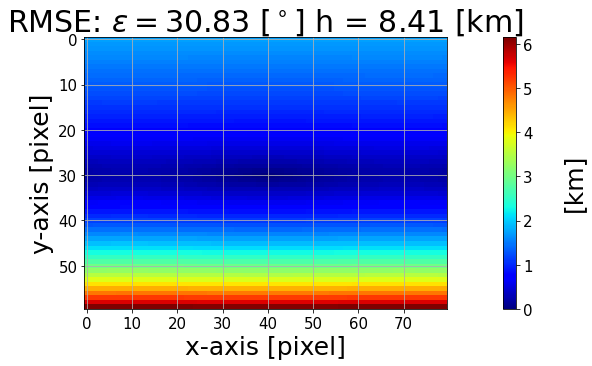

In [33]:
E_x_ = (X_flat_ - X_circ_)**2
E_y_ = (Y_flat_ - Y_circ_)**2

plt.figure(figsize = (20, 5))
plt.title(r'RMSE: $ \varepsilon = {} \ [^\circ]$ h = {} [km]'.format(np.around(epsilon, 2), 
                                                                np.around(height/1000., 2)), fontsize = 30)
plt.imshow(np.sqrt((E_x_ + E_y_)/2.)/1000., cmap = 'jet')
plt.xlabel('x-axis [pixel]', fontsize = 25)
plt.ylabel('y-axis [pixel]', fontsize = 25)
plt.colorbar().ax.tick_params(labelsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.text(107.5, 25, '[km]', va = 'top', ha = 'center', fontsize = 25, rotation = 90)
plt.grid()
plt.show()

In [34]:
def _zoom(x_, y_, latitude, longitude, scale):
    for i in range(2):
        print(x_[i], y_[i])
        x = (x_[i][1] - x_[i][0])
        z = (x_[i][1] - x_[i][0]) * scale
        w = (y_[i][1] - y_[i][0]) * scale
        print(z, w)
        z = (x - z)/2.
        w = int((y_[i][1] - w)/2.)
        print(z, w)
        x_[i][0] = x_[i][0] + z
        x_[i][1] = x_[i][1] - z
        y_[i][0] = y_[i][0] + w
        y_[i][1] = y_[i][1] - w
    return x_, y_

# lim_ = (-107.434, -105.69, 34.61, 35.596)
# #M_   = map_[172:-172, 261:-261, :]
# M_   = map_[172:-172, 261:-261, :]

# Load-up New Mexico Map
map_ = plt.imread(r'/Users/Guille/Desktop/geospatial_transformation/data/map.png')
n_y, n_x, _ = map_.shape
x_ = [[-108.660, -104.464], [33.966, 36.240]]
y_ = [[0, n_y], [0, n_x]]
lim_ = (x_[0][0], x_[0][1], x_[1][0], x_[1][1])
M_   = map_[y_[0][0]:y_[0][1], y_[1][0]:y_[1][1], :]

h = (-104.464 + 108.660)/n_x
k = (36.240 - 33.966)/n_y
print(h, k)

dx = -15
dy = 5

scale = .2
x_, y_ = _zoom(x_, y_, latitude, longitude, scale)
print(y_)
lim_ = (x_[0][0] + h*dx, x_[0][1] + h*dx, x_[1][0] - k*dy, x_[1][1] - k*dy)
M_   = map_[y_[0][0] + dy:y_[0][1] + dy, y_[1][0] + dx:y_[1][1] + dx, :]
print(lim_)
print(M_.shape)

0.004550976138828631 0.0037156862745098052
[-108.66, -104.464] [0, 612]
0.4615599999999998 67.32000000000001
1.867219999999999 272
[33.966, 36.24] [0, 922]
0.2501400000000001 101.42
1.0119300000000004 410
[[272, 340], [410, 512]]
(-106.86104464208242, -106.39948464208243, 34.959351568627454, 35.209491568627456)
(68, 102, 4)


(4800,) (4800,)


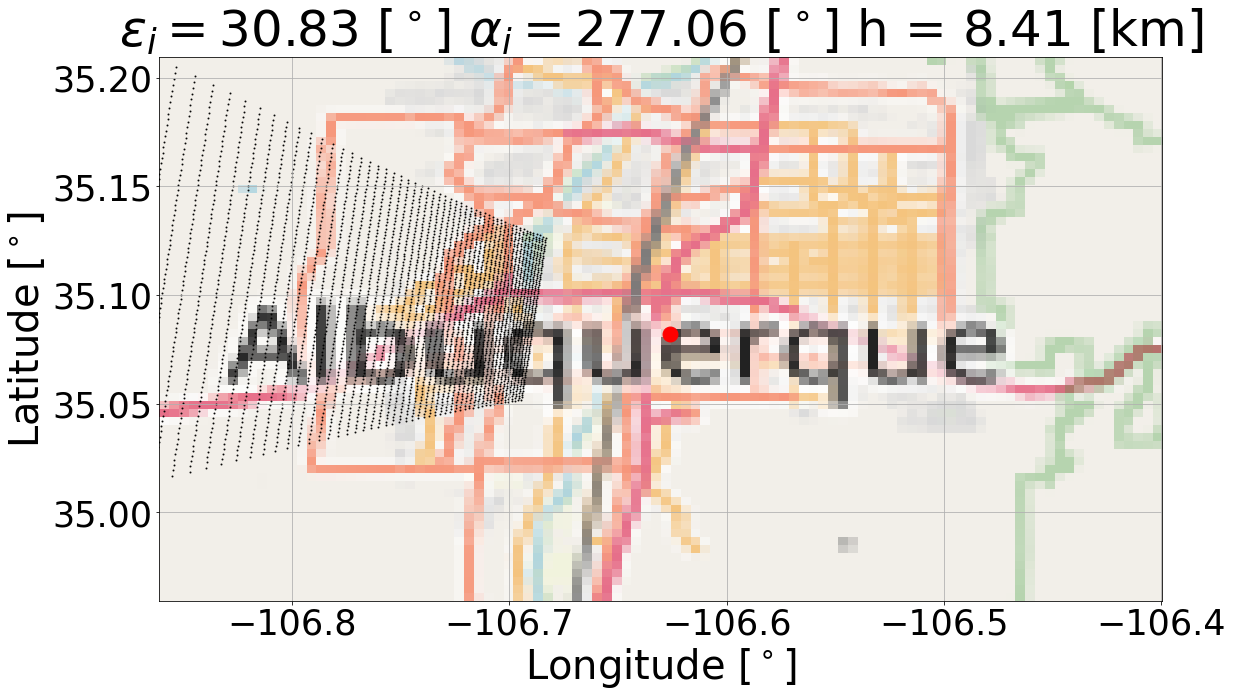

In [35]:
def __rotate_grid(X_, Y_, y_0, azimuth, longitude, latitude, height, r):
    azimuth   = np.radians(azimuth)
    latitude  = np.radians(latitude)
    longitude = np.radians(longitude)
    # Define Units System Transformation
    meters_per_latitude  = 110574
    meters_per_longitude = 111320*np.cos(latitude)
    # Define Scale Transformation
    rho = r / (r + height)
    # Define Rotation Transformation
    R_ = np.array([[np.cos(azimuth), -np.sin(azimuth)], [np.sin(azimuth), np.cos(azimuth)]])
    # Scale and tanslation Tranformation
    X_p_ = X_ * rho + x_0
    Y_p_ = Y_ * rho + y_0
    # Rotation Transformation
    XY_ = np.concatenate(( X_p_.flatten()[..., np.newaxis],  Y_p_.flatten()[..., np.newaxis]), axis = 1)
    XY_p_ = XY_ @ R_
    # Units Transformation from meters to degrees
    X_p_ = XY_p_[..., 0] / meters_per_longitude + np.degrees(longitude)
    Y_p_ = XY_p_[..., 1] / meters_per_latitude + np.degrees(latitude)
    return X_p_, Y_p_

X_circ_, Y_circ_ = _circle_perspective_reprojection(N_x, N_y, epsilon, height)

x_0 = X_circ_[30, 40]
y_0 = Y_circ_[30, 40]

X_p_, Y_p_ = __rotate_grid(X_circ_, Y_circ_, y_0, azimuth, longitude, latitude, height  = height - altitude, r= 6371000)
print(X_p_.shape, Y_p_.shape)

#lim_ = (-107.434, -105.69, 34.61, 35.596)
#M_   = map_[172:-172, 261:-261, :]

fig, ax = plt.subplots(figsize = (20, 10))
ax.set_title(r'$\varepsilon_i = {} \ [^\circ]$ $\alpha_i = {} \ [^\circ]$ h = {} [km]'.format(np.around(epsilon, 2), 
                                                np.around(azimuth, 2), np.around(height/1000., 2)), fontsize = 50)
ax.scatter(X_p_.flatten(), Y_p_.flatten(), alpha = .9, s = 1., c = 'k', label = r'Pixels')
#ax.scatter(X_p_, Y_p_, c = K_2_, s = dZ_circ_, marker = 's', cmap = 'inferno')
ax.scatter(longitude, latitude, zorder = 1, s = 250*(1. - scale), alpha = 1., c = 'r', marker = 'o')
ax.set_xlim(lim_[0], lim_[1])
ax.set_ylim(lim_[2], lim_[3])
#ax.legend(fontsize = 35, markerscale = 15,loc = 'upper right')
plt.imshow(M_, extent = lim_)
ax.set_xlabel('Longitude $[^\circ]$', fontsize = 40)
ax.set_ylabel('Latitude $[^\circ]$', fontsize = 40)
ax.tick_params(axis = 'both', which = 'major', labelsize = 35) 
ax.grid()
plt.show()

In [36]:
def _circle_perspective_reprojection_inc(N_x, N_y, epsilon, height, 
                                         altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
       
    # Project the Cross-Section plane in the Camera pLane in y-axis
    def __y_axis(epsilon_, height, R, r):
        
        # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(epsilon_, height, R, r):
            N = epsilon_.shape[0]
            # Compute quadratic formula coefficients for each elevation angle in a frame
            a_ = 1 + np.tan(epsilon_)**2
            b_ = 2. * r * np.tan(epsilon_)
            c_ = - np.ones(N) * height * (1. + 2.*r)
            #a_ = 1. + np.tan(epsilon_)**2
            #b_ = - 2. * r * np.tan(epsilon_)
            #c_ = - np.ones(N) * (R**2 - r**2)
            return np.stack((a_, b_, c_))
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, e_, height):
            N = e_.shape[0]
            x_ = np.zeros(N)
            y_ = np.zeros(N)
            z_ = np.zeros(N)
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                x_[i] = np.roots(W_[:, i])[1]
                y_[i] = x_[i] * np.tan(e_[i])
                z_[i] = y_[i] / np.sin(e_[i])
            return x_, y_, z_
    
        W_ = ___quadratic_coefficient(epsilon_, height, R, r)
        x_, y_, z_ = ___solve_quadratic_formula(W_, epsilon_, height)
        y_hat_ = r*np.arcsin(x_/r)
        y_hat_ = y_hat_ - y_hat_[0]
        return np.tile(y_hat_, (N_x, 1)).T, z_
    
    
   # Project the Cross-Section plane in the Camera pLane in x-axis
    def __x_axis(azimuth_, z_, height, R, r):
     # Compute coefficients of the Troposphere and Earth Surface Chords equation
        def ___quadratic_coefficient(azimuth_, z_, r_, height, R):
            N = z_.shape[0]
            M = azimuth_.shape[0]
            W_ = np.zeros((N, M, 3))
            # Compute quadratic formula coefficients for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    W_[i,j,0] = 1. + np.tan(azimuth_[j])**2 
                    W_[i,j,1] = -2.*r_[i] - 2.*z_[i]* (np.tan(azimuth_[j])**2)
                    W_[i,j,2] = (z_[i]**2) * (np.tan(azimuth_[j])**2)
            return W_
        # Solve Troposphere and Earth Surface Chords equation
        def ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R):
            N = W_.shape[0]
            M = W_.shape[1]
            L_ = np.zeros((N, M))
            X_hat_ = np.zeros((N, M))
            # Solve quadratic formula for each elevation angle in a frame
            for i in range(N):
                for j in range(M):
                    L_[i,j] = np.roots(W_[i, j, :])[1]
                    X_hat_[i,j] = r_[i]*np.arcsin(( (z_[i] - L_[i,j]) * np.tan(azimuth_[j]))/r_[i])
            return X_hat_
        r_ = np.zeros((z_.shape[0]))
        for i in range(z_.shape[0]):
            r_[i] = ( (4.*R*height - 2.*height**2)/z_[i] ) + 2.*z_[i]
        W_ = ___quadratic_coefficient(azimuth_, z_, r_, height, R)
        X_hat_ = ___solve_quadratic_formula(W_, azimuth_, z_, r_, height, R)
        return X_hat_
    
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        de   = (N_y/2)*radians_per_pixel
        e_0_ = np.linspace(epsilon + de, epsilon, 1 + int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel, epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Extend azimuth from camera FOV Angle for each pixel
    def __coordiantes_azimuth(N_x, radians_per_pixel):
        azimuth_ = np.linspace(0, N_x, N_x + 1)
        azimuth_ -= (N_x - 1)/2.
        azimuth_ *= radians_per_pixel
        return azimuth_
    
    # Elevation Angle from Degrees to Radiantes
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    # Sky-Parcel Geometric Constants
    r_earth = 6371000.     # Average Earth radius
    r = r_earth #+ altitude
    height = height - altitude
    R = r + height
    
    # Set the origen of the Coordinates plane in the Sun Position in the frame
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    azimuth_ = __coordiantes_azimuth(N_x, radians_per_pixel)

    # Get the axis distance and differential distances
    Y_, z_ = __y_axis(epsilon_, height, R, r) 
    X_ = __x_axis(azimuth_, z_, height, R, r)
    return np.diff(X_, axis = 0)[:, :-1], np.diff(Y_, axis = 0)

def _flat_perspective_reprojection_inc(N_x, N_y, epsilon, height, 
                                   altitude = 1630, FOV = 63.75, focal_length = 1.3669e-3, pixel_size = 17e-6):
    # Transform the Coordinates Plane to the Camera Plane
    def __camera_plane_coordinates(X_, Y_, pixel_size, focal_length):
        c = pixel_size/focal_length
        return X_ * c, Y_ * c
    # Project the Cross-Section plane in the Camera pLane
    def __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y):
        z_    = height/np.sin(epsilon_)
        X_p_ *= np.tile(z_, (N_x + 1, 1)).T
        Y_p_ *= np.tile(z_, (N_x + 1, 1)).T
        return X_p_, Y_p_
    # Extend Elevation from Sun's Elevation Angle for each pixel
    def __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel):
        de   = (N_y/2)*radians_per_pixel
        e_0_ = np.linspace(epsilon + de, epsilon, 1 + int(N_y/2))
        e_1_ = np.linspace(epsilon - radians_per_pixel, epsilon - de, int(N_y/2))
        return np.concatenate((e_0_, e_1_), axis = 0)
    
    # Sky-Parcel Geometric Constants
    height  = height - altitude
    epsilon = np.radians(epsilon)
    # Camera Specifications
    angles_per_pixel  = FOV/np.sqrt(N_x**2 + N_y**2)
    radians_per_pixel = np.radians(angles_per_pixel)
    FOV_x = radians_per_pixel * N_x
    FOV_y = radians_per_pixel * N_y
    
    # Sun's Position on the Cartenian Coordiantes
    X_, Y_ = np.meshgrid(np.linspace(0., N_x, N_x + 1), np.linspace(0., N_y, N_y + 1))
    X_ -= 39.5
    Y_ -= 29.5
    
    # Camera Plane Coordinates
    X_p_, Y_p_ = __camera_plane_coordinates(X_, Y_, pixel_size, focal_length)
    
    epsilon_ = __coordiantes_elevation(x_sun_, epsilon, N_y, radians_per_pixel)
    # Cross-Section Plane Coordinates
    X_pp_, Y_pp_ = __cross_section_plane_coordinates(X_p_, Y_p_, epsilon_, height, N_x, N_y)
    # Stack together the Coordinates system and the incrementes in the coordinates grid
    dX_ = np.diff(X_pp_, axis = 0)[:, :-1]
    dY_ = np.diff(Y_pp_, axis = 0)[:, :-1]
    return dX_, dY_